In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.models as models

In [19]:
# Pobierz Oxford 102 Flower Dataset, połącz train+val jako zestaw treningowy i utwórz DataLoadery

DATA_DIR = "./data/flowers102"
batch_size = 32

# Transformacje: augmentacja dla treningu, standaryzacja zgodna z ImageNet
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Pobranie podzbiorów (download tylko raz dla train)
train_ds = datasets.Flowers102(root=DATA_DIR, split="train", transform=train_transform, download=True)
val_ds = datasets.Flowers102(root=DATA_DIR, split="val", transform=train_transform, download=False)
test_ds = datasets.Flowers102(root=DATA_DIR, split="test", transform=test_transform, download=False)

# Połącz train + val jako ostateczny zbiór treningowy
train_dataset = torch.utils.data.ConcatDataset([train_ds, val_ds])

print(f"Rozmiar train (train+val): {len(train_dataset)}, rozmiar test: {len(test_ds)}")

# DataLoadery
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=False
)

Rozmiar train (train+val): 2040, rozmiar test: 6149


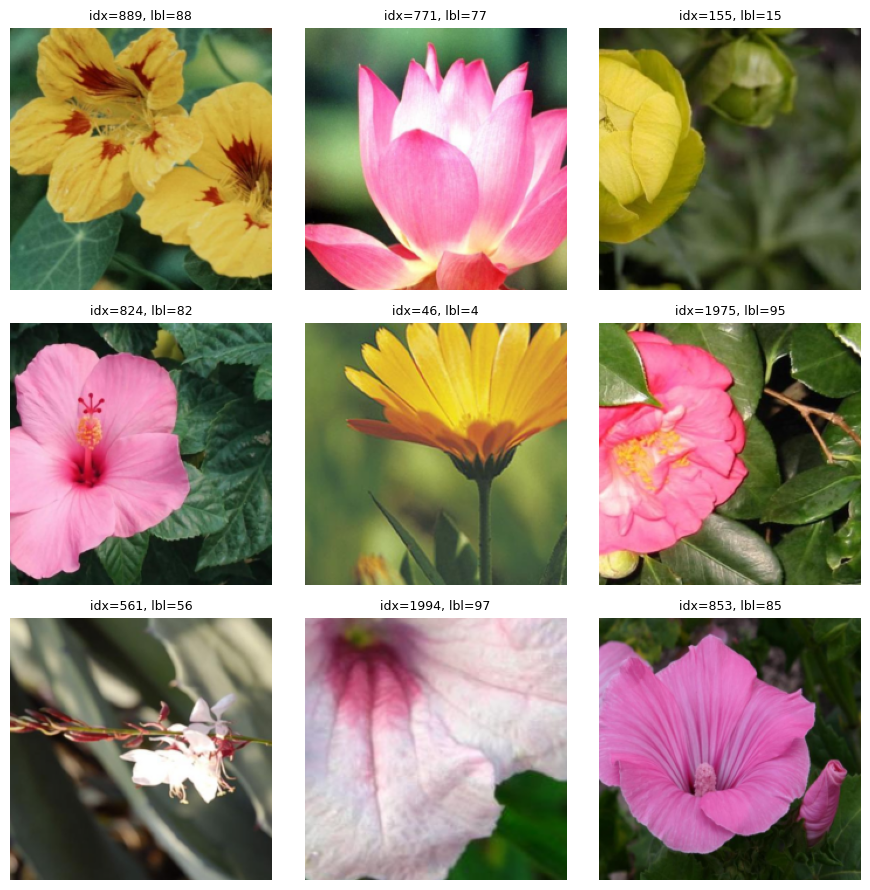

In [3]:
import numpy as np

# Wyświetl 9 przykładowych obrazków ze zbioru train_dataset (ConcatDataset)
import matplotlib.pyplot as plt

# funkcja do odnormalizowania i wyświetlenia obrazu
def show_image_tensor(img_tensor, ax, title=""):
    # img_tensor: torch.Tensor CxHxW (znormalizowany)
    img = img_tensor.cpu().numpy().transpose(1, 2, 0)  # HxWxC
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0.0, 1.0)
    ax.imshow(img)
    ax.axis("off")
    if title:
        ax.set_title(title, fontsize=9)

# wybierz 9 losowych indeksów ze zbioru treningowego
num_examples = 9
rng = np.random.default_rng()
indices = rng.choice(len(train_dataset), size=num_examples, replace=False)

fig, axes = plt.subplots(3, 3, figsize=(9, 9))
axes = axes.flatten()

for ax, idx in zip(axes, indices):
    img, label = train_dataset[idx]  # zwraca (tensor, label)
    show_image_tensor(img, ax, title=f"idx={idx}, lbl={label}")

plt.tight_layout()
plt.show()

In [ ]:
# Załaduj ResNet101 z wagami ImageNet (pobrane przez torchvision)
model101 = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V1)
model101.eval()

# Przenieś na GPU jeśli dostępne (device zdefiniowany w dalszej komórce można użyć, 
# ale żeby być bezpiecznym względem kolejności wykonania, ustawiamy lokalnie)
device = "cpu"
model101.to(device)

print("ResNet101 załadowany z wagami torchvision. Device:", device)

# # Zapisz state_dict
# res101_path = f"{DATA_DIR}/resnet101_imagenet1k_v1.pth"
# torch.save(model101.state_dict(), res101_path)
# print("Zapisano wagi ResNet101 do:", res101_path)

print(model101)

ResNet101 załadowany z wagami torchvision. Device: cpu
Zapisano wagi ResNet101 do: ./data/flowers102/resnet101_imagenet1k_v1.pth
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [11]:
# Zamroź ostatnią warstwę (fc) w model101
for p in model101.parameters():
    p.requires_grad = False

# Potwierdzenie statusu zamrożenia
print("Status parametrów warstwy 'fc' w model101:")
for name, p in model101.named_parameters():
    if name.startswith("fc."):
        print(f"{name}: requires_grad={p.requires_grad}")

Status parametrów warstwy 'fc' w model101:
fc.weight: requires_grad=False
fc.bias: requires_grad=False


In [12]:
# Zamień ostatnią warstwę fc na nową z 102 wyjściami (kategorie)
in_features = model101.fc.in_features
model101.fc = torch.nn.Linear(in_features, 102)

# Proste zainicjalizowanie wag i biasów
torch.nn.init.normal_(model101.fc.weight, mean=0.0, std=0.01)
torch.nn.init.zeros_(model101.fc.bias)

# Upewnij się, że nowa warstwa jest trenowalna i model na właściwym device
for p in model101.fc.parameters():
    p.requires_grad = True

model101.to(device)
model101.train()  # tryb treningowy, jeśli dalej będziesz trenować (możesz ustawić eval() później)

# Potwierdzenie
print("Nowa warstwa fc:", model101.fc)
print("Status parametrów warstwy 'fc':")
for name, p in model101.named_parameters():
    if name.startswith("fc."):
        print(f"{name}: requires_grad={p.requires_grad}, shape={tuple(p.shape)}")

trainable_params = sum(p.numel() for p in model101.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model101.parameters())
print(f"Trainable params: {trainable_params} / Total params: {total_params}")

Nowa warstwa fc: Linear(in_features=2048, out_features=102, bias=True)
Status parametrów warstwy 'fc':
fc.weight: requires_grad=True, shape=(102, 2048)
fc.bias: requires_grad=True, shape=(102,)
Trainable params: 208998 / Total params: 42709158


In [21]:
# Przygotowanie do treningu modelu model101 na danych treningowych
# Użyj train_loader z train_dataset (train+val) przez 4 epoki

# Parametry treningu
num_epochs = 4
learning_rate = 1e-3

# Loss i optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model101.fc.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

# Upewnij się, że model jest na właściwym urządzeniu i w trybie treningowym
model101.to(device)
model101.train()

print(f"Rozpoczynam trening na {len(train_dataset)} próbkach treningowych")
print(f"Liczba batchy: {len(train_loader)}, batch_size: {batch_size}")
print(f"Device: {device}\n")

# Pętla treningowa
for epoch in range(1, num_epochs + 1):
    model101.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model101(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statystyki
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, dim=1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)
        
        # Progress co 10 batchy
        if (batch_idx + 1) % 1 == 0:
            print(f"Epoch {epoch}/{num_epochs}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}")
    
    # Update learning rate
    scheduler.step()
    
    # Statystyki epoki
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    current_lr = scheduler.get_last_lr()[0]
    
    print(f"\nEpoch {epoch}/{num_epochs} Summary:")
    print(f"  Loss: {epoch_loss:.4f}")
    print(f"  Accuracy: {epoch_acc:.4f} ({correct}/{total})")
    print(f"  Learning Rate: {current_lr:.6f}\n")

print("Trening zakończony!")

# # Zapisz wytrenowany model
# finetuned_path = f"{DATA_DIR}/resnet101_finetuned_flowers102.pth"
# torch.save(model101.state_dict(), finetuned_path)
# print(f"Zapisano wytrenowany model do: {finetuned_path}")

Rozpoczynam trening na 2040 próbkach treningowych
Liczba batchy: 64, batch_size: 32
Device: cpu



Epoch 1/4, Batch 1/64, Loss: 4.6005
Epoch 1/4, Batch 2/64, Loss: 4.6310
Epoch 1/4, Batch 3/64, Loss: 4.6150
Epoch 1/4, Batch 4/64, Loss: 4.6281
Epoch 1/4, Batch 5/64, Loss: 4.7316
Epoch 1/4, Batch 6/64, Loss: 4.5685
Epoch 1/4, Batch 7/64, Loss: 4.5871
Epoch 1/4, Batch 8/64, Loss: 4.6394
Epoch 1/4, Batch 9/64, Loss: 4.6559
Epoch 1/4, Batch 10/64, Loss: 4.6017
Epoch 1/4, Batch 11/64, Loss: 4.5761
Epoch 1/4, Batch 12/64, Loss: 4.6327
Epoch 1/4, Batch 13/64, Loss: 4.6408
Epoch 1/4, Batch 14/64, Loss: 4.5969
Epoch 1/4, Batch 15/64, Loss: 4.6053
Epoch 1/4, Batch 16/64, Loss: 4.6654
Epoch 1/4, Batch 17/64, Loss: 4.6245
Epoch 1/4, Batch 18/64, Loss: 4.5856
Epoch 1/4, Batch 19/64, Loss: 4.5880
Epoch 1/4, Batch 20/64, Loss: 4.4750
Epoch 1/4, Batch 21/64, Loss: 4.4778
Epoch 1/4, Batch 22/64, Loss: 4.6883
Epoch 1/4, Batch 23/64, Loss: 4.6975
Epoch 1/4, Batch 24/64, Loss: 4.5229
Epoch 1/4, Batch 25/64, Loss: 4.6488
Epoch 1/4, Batch 26/64, Loss: 4.5090
Epoch 1/4, Batch 27/64, Loss: 4.6283
Epoch 1/4,

KeyboardInterrupt: 